In [42]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
from shapely import box
from scipy.stats import ks_2samp

import config.settings as cset

import matplotlib
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgba
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerTuple
from mpl_toolkits.axes_grid1 import make_axes_locatable
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            )

from tqdm.notebook import tqdm


plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['hatch.linewidth'] = cset.hatch_linewidth 
# Set global linewidth for all plotted lines
mpl.rcParams['lines.linewidth'] = cset.linewidth  # adjust as needed

# Set global linewidth for figure borders (spines)
mpl.rcParams['axes.linewidth'] = cset.border_linewidth   # frame around plots
mpl.rcParams['xtick.labelsize'] = labelsize_small
mpl.rcParams['ytick.labelsize'] = labelsize_small
mpl.rcParams['axes.labelsize'] = labelsize_medium
mpl.rcParams['axes.titlesize'] = labelsize_large
mpl.rcParams['legend.fontsize'] = labelsize_medium

mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1


In [43]:
# Function to extract per-ensemble-member country median for each scenario group
def get_ensemble_medians(df, dataset_label):
    rows = []
    for scenario_prefix in cset.focus_scenarios:  # Add more as needed
        scenario_cols = [col for col in df.columns if col.startswith(scenario_prefix)]
        for col in scenario_cols:
            country_median = df[col].median()
            rows.append({
                'Scenario': scenario_prefix,
                'EnsembleMember': col,
                'MedianValue': country_median,
                'Dataset': dataset_label
            })
    return pd.DataFrame(rows)

## Settings

In [44]:
thrshld = 1.35
thrshld_str = '135'
gmt_char = 'gmt_ntwr'

## Load Data

In [45]:
gdp_dfs = [pd.read_csv(cset.path_INTERIM_GDP / file_name) for file_name in cset.GDP_interim_dataset_names]

In [46]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

In [47]:
median_gmt_ds = pd.DataFrame(index=gmt_ds.index)
for scenario in cset.scenarios:
    scenario_cols = [col for col in gmt_ds.columns if col.startswith(scenario)]
    median_gmt_ds[scenario] = gmt_ds[scenario_cols].median(axis=1)

In [48]:
# load reversibility dataset
reversibility_df = pd.read_csv(cset.reversibility_file)

## Plotting Functions

In [62]:
def beyond_peak_warming_median_swapped(ax, gdp_dfs, scenarios, markers, linestyles, labels, color_dict, y_ticks = [1.25, 1.5, 1.75, 2.0, 2.25], x_bounds = (-0, -40)):
    for gdp_df, marker, label, linestyle in zip(gdp_dfs, markers, labels, linestyles):
        for scenario in scenarios:
            base_color = mcolors.to_rgb(color_dict[scenario])
            light_color = mcolors.to_rgb(mcolors.to_hex([min(1, c + 0.5 * (1 - c)) for c in base_color]))
            cmap = mcolors.LinearSegmentedColormap.from_list(f'{scenario}_cmap', [light_color, base_color], N=256)
            cmap = matplotlib.colormaps["viridis_r"]

            df_scenario = gdp_df[gdp_df['scen_run'].str.contains(scenario)]
            median_global = df_scenario.groupby('year')['SSP2_diff'].median() * 100
            gmt = gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].median(axis=1)
            years = median_global.index

            # Compute GDP loss
            gdp_loss = -(100 - median_global)

            # Plot: x = GDP loss, y = GMT
            ax.plot(
                gdp_loss.values,
                gmt.loc[years],
                c=base_color,
                linestyle=linestyle
            )

            for year, color in zip([2050, 2075, 2100], ['grey', 'grey', 'grey']):
                ax.scatter(
                    -(100 - median_global.loc[year]),
                    gmt.loc[year],
                    color=color,
                    zorder=10,
                    edgecolors=base_color,
                    marker='o',
                    s=cset.marker_size
                )
                ax.axhline(gmt.loc[year], color=color, linestyle=(0, (3, 1, 1, 1)))
                ax.text(-39, gmt.loc[year] + 0.005,
                        f'{int(year)}', color=color, fontsize=labelsize_medium, ha = 'right')

    # Highlight Ref 2100 point
    scenario = 'Ref'
    year = 2100
    gdp_df = gdp_dfs[2]
    df_scenario = gdp_df[gdp_df['scen_run'].str.contains('Ref')]
    median_global = df_scenario.groupby('year')['SSP2_diff'].median() * 100
    gmt = gmt_ds.loc[:, gmt_ds.columns.str.contains('Ref')].median(axis=1)

    ax.scatter(
        -(100 - median_global.loc[year]),
        gmt.loc[year],
        color=cset.focus_scenarios_color_dict[scenario],
        zorder=10,
        edgecolors=cset.focus_scenarios_color_dict[scenario],
        marker='*',
        s=cset.marker_size * 2
    )
    
    ax.text(
        -(100 - median_global.loc[year]),
        gmt.loc[year]-0.04,
        f'{cset.scenario_names_dict[scenario]} in 2100',
        color=cset.focus_scenarios_color_dict[scenario],
        fontsize=labelsize_small,
        ha='center'
    )
    
    scenario = 'GS'
    year = 2100
    gdp_df = gdp_dfs[2]
    df_scenario = gdp_df[gdp_df['scen_run'].str.contains(scenario)]
    median_global = df_scenario.groupby('year')['SSP2_diff'].median() * 100
    gmt = gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].median(axis=1)

    ax.scatter(
        -(100 - median_global.loc[year]),
        gmt.loc[year],
        color=cset.focus_scenarios_color_dict[scenario],
        zorder=10,
        edgecolors=cset.focus_scenarios_color_dict[scenario],
        marker='*',
        s=cset.marker_size * 2
    )
    
    ax.text(
        -(100 - median_global.loc[year]),
        gmt.loc[year]-0.04,
        f'{cset.scenario_names_dict[scenario]} in 2100',
        color=cset.focus_scenarios_color_dict[scenario],
        fontsize=labelsize_small,
        ha='center'
    )

    # Legend
    custom_style_handles = [
        Line2D([0], [0], color='grey', linestyle=style, label=label)
        for label, style in zip(labels, linestyles)
    ]

    # Adjust axis settings
    ax.set_xlabel('GDP change relative to baseline (%)', fontsize=labelsize_medium)
    ax.set_ylabel('GMT (°C)', fontsize=labelsize_medium)
    ax.set_yticks(y_ticks)
    ax.set_xlim(x_bounds)  # More negative values on right
    ax.legend(
        handles=custom_style_handles,
        ncol=1,
        fontsize=labelsize_medium,
        facecolor=(1, 1, 1, 0.7),
        edgecolor='none'
    )
    return

In [50]:
def beyond_peak_warming_countries_swapped(ax, countries, labels, color_dict, scenario = 'Neg', country_colors = ['#B36D3D', '#F1B97F'], gdp_df = gdp_dfs[1], global_linestyle = '-',  legend_label=cset.GDP_labels[1], y_bounds = (1.15, 1.75),  y_ticks = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]):
    # --- Loop over each damage function ---
    # plot global meidan
    base_color = mcolors.to_rgb(color_dict[scenario])

    df_scenario = gdp_df[gdp_df['scen_run'].str.contains(scenario)].copy()
    df_scenario.loc[:, 'SSP2_diff'] = (1-df_scenario.loc[:, 'SSP2_diff'])
    
    # Global median
    median_global = df_scenario.groupby('year')['SSP2_diff'].median()
    median_global *= 100
    gmt = gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].median(axis=1)
    years = median_global.index
    
    country_data = df_scenario.groupby(['year', 'iso'])['SSP2_diff'].median().reset_index().pivot(index='year', columns='iso', values='SSP2_diff')
    country_data *= 100
    
    # individual countries
    # ax.plot(
    #          gmt.loc[years], country_data.values,
    #          color = base_color,
    #          alpha  = .2,
    #          lw = .1
    #      )
    ax.scatter(country_data.loc[2058, :].values, [gmt.loc[2057]]*157, color = base_color, marker ='*', s = cset.marker_size, alpha = .7, label = 'All countries \n in 2057')
    
    ax.plot(
        median_global.values,
        gmt.loc[years], 
        c = base_color,
        linestyle = global_linestyle,
        label = 'Global',
    )

    for year in [2050, 2075, 2100]:
        ax.scatter(median_global.loc[year], gmt.loc[year], color = base_color, edgecolors = 'grey', marker ='o', s = cset.marker_size, zorder = 10)             
        ax.axhline(gmt.loc[year], color = 'grey', linestyle = (0, (3,1,1,1)))
        ax.text(15, gmt.loc[year]-0.015, f'{int(year)}', color = 'grey', fontsize = labelsize_medium, ha = 'right')
    
    for label, country, color in zip(labels, countries, country_colors):
        median_country = df_scenario[df_scenario['iso'] == country].groupby('year')['SSP2_diff'].median()
        median_country *= 100
        gmt = gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].median(axis=1)
        # plot global median GDP: 
        ax.plot(
            median_country.values,
            gmt.loc[years], 
            color = color,
            label= label,
            zorder = 10
        )
        for year in [2050, 2075, 2100]:
            ax.scatter(median_country.loc[year], gmt.loc[year], color = color, zorder = 10, edgecolors = 'grey', marker ='o', s = cset.marker_size)            
    
    ax.set_xticks([-15, -7.5, 0, 7.5, 15], [15, 7.5, 0, -7.5, -15])
    ax.set_yticks(y_ticks)
    # ax.set_yticks([1.25, 1.5, 1.75])    
    
    # --- Final plot styling ---
    ax.set_ylabel('GMT (°C)')
    ax.set_xlabel('GDP change relative to baseline (%)')
    # ax.grid(True)
    # ax.set_ylim(y_bounds)
    # legend = ax.legend(ncol=2, fontsize = labelsize_medium, facecolor = (1,1,1,0.7), edgecolor = 'none')
    # First create a fake handle for the "title"
    # Get actual legend handles and labels
    # Get current handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Create legend without a title (to allow manual positioning)
    legend = ax.legend(
        handles=handles,
        labels=labels,
        ncol=1,
        fontsize=labelsize_medium,
        facecolor=(1, 1, 1, 0.7),
        edgecolor='none',
        frameon=True,
        loc='lower left',
        handlelength = 1.5, 
        columnspacing = 1.5
    )

    # Add manual "title" using ax.text, placed just above the legend
    legend_x, legend_y = legend.get_frame().get_bbox().bounds[:2]
    # legend.get_frame().get_height() 
    ax.text(
        legend_x + 0.01,
        legend_y + 0.1 + 0.09,  # 5 is vertical spacing tweak
        legend_label,
        fontsize=labelsize_medium,
        ha='left',
        va='bottom',
        transform=ax.transAxes, 
        zorder = 10
    )
    return()

In [51]:
def adjust_color(color, factor):
    """Lighten or darken a color by a given factor."""
    c = mcolors.to_rgb(color)
    return tuple(min(max(channel * factor, 0), 1) for channel in c)

def plot_scenario_barplot(ax, df, scenario, color_dict):
    """
    Plot GDP loss for a single scenario on a given axis.
    
    Parameters:
        ax: matplotlib.axes.Axes - axis to draw on
        df: pd.DataFrame - dataframe with columns ['DamageType', 'Scenario', 'Year', 'MedianGDPloss']
        scenario: str - name of the scenario to plot
        color_dict: dict - scenario name to base color mapping
    """
    # Define the order of the bars
    year_order = ['Before', 'Peak', 'After']

    # Filter data for the specified scenario
    df_scen = df[df['Scenario'] == scenario].copy()

    # # Sort to ensure consistent plotting order
    # df_scen['Year'] = pd.Categorical(df_scen['Year'], categories=year_order, ordered=True)
    # df_scen = df_scen.sort_values(['DamageType', 'Year'])

    # Define base, lighter, and darker colors
    base_color = color_dict[scenario]
    color_map = {
        'Prior': adjust_color(base_color, 1.3),
        'Peak': base_color,
        '2075': adjust_color(base_color, .7),
    }

    # Plotting
    damage_types = df_scen['DamageType'].unique()
    bar_width = 0.25
    x = np.arange(len(damage_types))

    labels = ['before peak warming', 'peak warming', 'after peak warming']
    for i, year in enumerate(year_order):
        label = str(np.round(df_scen[(df_scen.Year == year)].loc[:, 'GMT'].values[0], 2)) + '°C in ' +  str(int(df_scen[(df_scen.Year == year)].loc[:, 'Year numeric'].values[0]))
        year_data = df_scen[df_scen['Year'] == year]
        offsets = x + (i - 1) * bar_width  # center bars
        ax.bar(
            offsets,
            year_data['MedianGDPloss'],
            width=bar_width,
            label=label,
            color=color_map[year]
        )

    ax.set_xticks(x)
    ax.set_xticklabels(damage_types)
    ax.set_ylabel('GDP change relative to baseline (%)')
    # ax.set_title(f'Scenario: {scenario}', fontsize=labelsize_small)
    legend = ax.legend(facecolor = (1, 1, 1, 0.7), edgecolor = 'none', fontsize = labelsize_small)
    # legend.get_title().set_fontsize(labelsize_medium)

In [52]:
def plot_scenario_broken_y(fig, gs, df, scenario, color_dict, y_break=1, gap=0.1, y_ticks_bottom = [0.25, 0.5, 0.75], y_ticks_top = None):
    """
    Create a barplot with a broken y-axis to highlight small values.

    Parameters:
        df: pd.DataFrame – filtered input data
        scenario: str – scenario to plot
        color_dict: dict – base color for each scenario
        y_break: float – value at which to break the y-axis (e.g., 1%)
        gap: float – size of visual gap between bottom and top axes
    """
    # Setup
    year_order = ['Before', 'Peak', 'After']
    base_color = color_dict[scenario]
    color_map = {
        'Before': adjust_color(base_color, 1.3),
        'Peak': base_color,
        'After': adjust_color(base_color, 0.7),
    }

    df_scen = df[df['Scenario'] == scenario].copy()
    damage_types = df_scen['DamageType'].unique()
    n_damage = len(damage_types)
    bar_width = 0.25
    x = np.arange(n_damage)

    # Create figure and subplots
    gs_inner = gridspec.GridSpecFromSubplotSpec(
            nrows=2, ncols=1,
            height_ratios = [2,1],
            subplot_spec=gs,
            hspace=gap
    )
    ax_top = fig.add_subplot(gs_inner[0])
    ax_bottom = fig.add_subplot(gs_inner[1], sharex=ax_top)

    year_strings = ['prior', 'peak', 'after']
    # Plot bars on both axes
    for i, year in enumerate(year_order):
        year_data = df_scen[df_scen['Year'] == year]
        offsets = x + (i - 1) * bar_width
        color = color_map[year]
        label = f"{year_data['GMT'].values[0]:.1f}°C  {year_strings[i]}"
        heights = year_data['MedianGDPloss'].values
        # heights = -year_data['MedianGDPloss'].values

        # Split into below/above y_break
        ax_bottom.bar(offsets, heights, width=bar_width, color=color, zorder=3)
        ax_top.bar(offsets, heights, width=bar_width, color=color, zorder=3,  label=label)

    # Set y-limits
    ax_bottom.set_ylim(0, y_break)
    ax_top.set_ylim(y_break + 0.1, df_scen['MedianGDPloss'].max() * 1.1)

    # Hide ticks between the two plots
    ax_top.spines['bottom'].set_visible(False)
    ax_bottom.spines['top'].set_visible(False)
    ax_top.tick_params(labelbottom=False)
    ax_bottom.xaxis.tick_bottom()

    # Add diagonal break marks
    d = 0.015
    kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
    ax_top.plot((-d, +d), (-d, +d), **kwargs)
    ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_bottom.transAxes)
    ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax_bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Set x-ticks and labels
    ax_bottom.set_xticks(x)
    ax_bottom.set_xticklabels(damage_types)

    # Get the bounding boxes of the two axes in figure coordinates
    bbox_top = ax_top.get_position()
    bbox_bottom = ax_bottom.get_position()

    # Compute the vertical center between the two subplots
    y_center = (bbox_top.y1 + bbox_bottom.y0) / 2

    # Compute a left-aligned x-position based on left edge of ax_bottom
    x_pos = bbox_bottom.x0 - 0.04  # small offset for padding

    # Add the y-label at the computed position
    fig.text(x_pos, y_center, "GDP change relative to baseline (%)", va='center', ha='right', rotation='vertical', fontsize=labelsize_medium)
    
    #ax_top.set_ylabel("Median GDP Loss (%)")
    ax_top.set_ylabel("")
    ax_bottom.set_ylabel("")
    
    ax_top.tick_params(labelbottom=False, bottom=False)
    ax_bottom.set_yticks(y_ticks_bottom)
    if y_ticks_top is not None:
        ax_top.set_yticks(y_ticks_top)
    
    ax_bottom.set_yticklabels(
        [f"-{label.get_text().lstrip('-')}" for label in ax_bottom.get_yticklabels()]
    )
    ax_top.set_yticklabels(
        [f"-{label.get_text().lstrip('-')}" for label in ax_top.get_yticklabels()]
    )
    
    # Only one legend
    ax_top.legend(facecolor=(1, 1, 1, 0.7), edgecolor='none')

    return ax_top, ax_bottom

In [53]:
def plot_scenario_broken_y(fig, gs, df, scenarios, color_dict, y_break=1, gap=0.1, 
                           y_ticks_bottom=[0.25, 0.5, 0.75], y_ticks_top=None):
    """
    Create a barplot with a broken y-axis to highlight small values.
    Optionally plots a second scenario as overlay.

    Parameters:
        scenarios: str or list/tuple of up to 2 scenarios (e.g., ['Neg', 'Ref'])
    """
    if isinstance(scenarios, str):
        scenarios = [scenarios]  # Handle single scenario

    year_order = ['Before', 'Peak', 'After']
    year_strings = ['prior', 'peak', 'after']

    # Setup plotting
    gs_inner = gridspec.GridSpecFromSubplotSpec(
        nrows=2, ncols=1,
        height_ratios=[2, 1],
        subplot_spec=gs,
        hspace=gap
    )
    ax_top = fig.add_subplot(gs_inner[0])
    ax_bottom = fig.add_subplot(gs_inner[1], sharex=ax_top)

    damage_types = df['DamageType'].unique()
    n_damage = len(damage_types)
    bar_width = 0.25
    x = np.arange(n_damage)

    for scen_idx, scenario in enumerate(scenarios):
        df_scen = df[df['Scenario'] == scenario].copy()
        base_color = color_dict[scenario]

        color_map = {
            'Before': adjust_color(base_color, 1.3),
            'Peak': base_color,
            'After': adjust_color(base_color, 0.7),
        }

        for i, year in enumerate(year_order):
            year_data = df_scen[df_scen['Year'] == year]
            offsets = x + (i - 1) * bar_width
            color = color_map[year]
            label = f"{year_data['GMT'].values[0]:.1f}°C {year_strings[i]}" if scen_idx == 0 else None
            heights = year_data['MedianGDPloss'].values

            if scen_idx == 0:
                ax_bottom.bar(offsets, heights, width=bar_width, color=color, zorder=3)
                ax_top.bar(offsets, heights, width=bar_width, color=color, zorder=3, label=label)
            else:
                # Plot comparison scenario as outline or semi-transparent overlay
                ax_bottom.bar(offsets, heights, width=bar_width, color=color,  edgecolor='none', zorder=4)
                ax_top.bar(offsets, heights, width=bar_width, color=color, edgecolor='none',  zorder=4, label = f'1.5°C')

    # # Y-axis setup
    # ax_bottom.set_ylim(0, y_break)
    # ax_top.set_ylim(y_break + 0.1, df['MedianGDPloss'].max() * 1.1)

    # ax_top.spines['bottom'].set_visible(False)
    # ax_bottom.spines['top'].set_visible(False)
    # ax_top.tick_params(labelbottom=False)
    # ax_bottom.xaxis.tick_bottom()

    # # Diagonal break marks
    # d = 0.015
    # kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
    # ax_top.plot((-d, +d), (-d, +d), **kwargs)
    # ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    # kwargs.update(transform=ax_bottom.transAxes)
    # ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    # ax_bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # ax_bottom.set_xticks(x)
    # ax_bottom.set_xticklabels(damage_types)

    # bbox_top = ax_top.get_position()
    # bbox_bottom = ax_bottom.get_position()
    # y_center = (bbox_top.y1 + bbox_bottom.y0) / 2
    # x_pos = bbox_bottom.x0 - 0.04
    # fig.text(x_pos, y_center, "GDP change relative to baseline (%)", va='center', ha='right', rotation='vertical', fontsize=labelsize_medium)

    # ax_top.set_ylabel("")
    # ax_bottom.set_ylabel("")
    # ax_top.tick_params(labelbottom=False, bottom=False)
    # ax_bottom.set_yticks(y_ticks_bottom)
    # if y_ticks_top is not None:
    #     ax_top.set_yticks(y_ticks_top)

    # ax_bottom.set_yticklabels([f"-{label.get_text().lstrip('-')}" for label in ax_bottom.get_yticklabels()])
    # ax_top.set_yticklabels([f"-{label.get_text().lstrip('-')}" for label in ax_top.get_yticklabels()])

    # Set y-limits
    df_scen = df[df['Scenario'] == scenarios[0]].copy()
    ax_bottom.set_ylim(0, y_break)
    ax_top.set_ylim(y_break + 0.1, df_scen['MedianGDPloss'].max() * 1.1)

    # Hide ticks between the two plots
    ax_top.spines['bottom'].set_visible(False)
    ax_bottom.spines['top'].set_visible(False)
    ax_top.tick_params(labelbottom=False)
    ax_bottom.xaxis.tick_bottom()

    # Add diagonal break marks
    d = 0.015
    kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
    ax_top.plot((-d, +d), (-d, +d), **kwargs)
    ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_bottom.transAxes)
    ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax_bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Set x-ticks and labels
    ax_bottom.set_xticks(x)
    ax_bottom.set_xticklabels(damage_types)

    # Get the bounding boxes of the two axes in figure coordinates
    bbox_top = ax_top.get_position()
    bbox_bottom = ax_bottom.get_position()

    # Compute the vertical center between the two subplots
    y_center = (bbox_top.y1 + bbox_bottom.y0) / 2

    # Compute a left-aligned x-position based on left edge of ax_bottom
    x_pos = bbox_bottom.x0 - 0.04  # small offset for padding

    # Add the y-label at the computed position
    fig.text(x_pos, y_center, "GDP change relative to baseline (%)", va='center', ha='right', rotation='vertical', fontsize=labelsize_medium)
    
    #ax_top.set_ylabel("Median GDP Loss (%)")
    ax_top.set_ylabel("")
    ax_bottom.set_ylabel("")
    
    ax_top.tick_params(labelbottom=False, bottom=False)
    ax_bottom.set_yticks(y_ticks_bottom)
    if y_ticks_top is not None:
        ax_top.set_yticks(y_ticks_top)
    
    ax_bottom.set_yticklabels(
        [f"-{label.get_text().lstrip('-')}" for label in ax_bottom.get_yticklabels()]
    )
    ax_top.set_yticklabels(
        [f"-{label.get_text().lstrip('-')}" for label in ax_top.get_yticklabels()]
    )
    

    if len(scenarios) == 1:
        ax_top.legend(facecolor=(1, 1, 1, 0.7), edgecolor='none')
    else: 
        ax_top.legend(facecolor=(1, 1, 1, 0.7), edgecolor='none', ncols = 2)
    return ax_top, ax_bottom


/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_58016/1366606784.py:142: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_top.set_yticklabels(


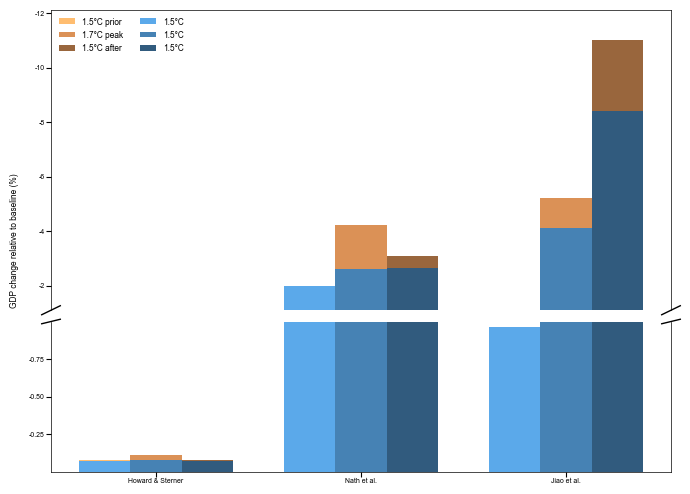

In [54]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1, figure=fig)
plot_scenario_broken_y(fig, gs[0], reversibility_df, ['Neg', 'Ref'], cset.scenarios_color_dict, gap = 0.05)
plt.show()

In [55]:
def plot_gdp_half_violin(
    ax,
    gdp_dfs,
    selected_year,
    sel_var,
    focus_scenarios_color_dict
):
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]

    width = 0.8
    scenario_order = ['Ref', 'Neg']

    for i_df, gdp_df in enumerate(gdp_dfs):
        for i_scen, scen in enumerate(scenario_order):
            gdp_tmp = (
                gdp_df[gdp_df['scen'] == scen]
                .query("year == @selected_year")
                .loc[:, ['iso', sel_var]]
                .groupby('iso')
                .median() * 100
            )
            # Remove outliers
            gdp_tmp = gdp_tmp[gdp_tmp.values <= 1.1 * gdp_tmp.quantile(0.99).values[0]]

            side = 'low' if scen == 'Ref' else 'high'
            pos = i_df

            # Plot half violin
            pc = ax.violinplot(
                gdp_tmp.values.flatten(),
                positions=[pos],
                widths=width,
                showextrema=False,
                side=side  # Custom matplotlib extension required, otherwise remove
            )

            for body in pc['bodies']:
                body.set_facecolor(face_colors[i_scen])
                body.set_edgecolor(edge_colors[i_scen])

            # Quantiles and min–max
            values = gdp_tmp.values.flatten()
            qvals = [0.05, 0.5, 0.95]
            markers = ['v', 'o', '^']
            offset = -width / 4 if scen == 'Ref' else width / 4

            for q, marker in zip(qvals, markers):
                ax.scatter(
                    [pos + offset],
                    [np.quantile(values, q)],
                    marker=marker,
                    color=edge_colors[i_scen],
                    zorder=3,
                    s = cset.marker_size,
                )

            # Min–max line
            min_val = values.min()
            max_val = values.max()
            ax.plot(
                [pos, pos],
                [min_val, max_val],
                color=edge_colors[i_scen],
                marker='_',
                markersize=cset.marker_size,
                linewidth=1,
                linestyle='--',
                solid_capstyle='round',
                zorder=2,
            )

    # Labels and styling
    ax.set_xlim(-0.5, len(gdp_dfs) - 0.5)
    ax.set_xticks(range(len(gdp_dfs)), cset.GDP_labels)
    # ax.set_xticklabels(cset.GDP_files, fontsize=labelsize_small)
    ax.set_ylabel('GDP in 2057 \n relative to baseline (%)', fontsize=labelsize_medium)
    ax.set_xlabel('Damage function', fontsize=labelsize_medium)
    # ax.set_title(f'GDP distribution in {selected_year}', fontsize=labelsize_large)
    ax.set_ylim(51, 140)
    ax.text(-0.3, 60, 'Differences in distributions persist until:', fontsize = labelsize_small)
    ax.text(0,55, '2074', fontsize = labelsize_small, ha = 'center')
    ax.text(1,55, '2087', fontsize = labelsize_small, ha = 'center')
    ax.text(2,55, 'at least 2100', fontsize = labelsize_small, ha = 'center')

    # Legend
    legend_elements = [
        Line2D([], [], color='gray', marker='', linestyle = '-', lw=1, label='Min–Max'),
        Line2D([], [], color='gray', marker='o', markersize = cset.marker_size/2, lw=0, label='Median'),
        Line2D([], [], color='gray', marker='v', markersize = cset.marker_size/2, lw=0, label='5th quantile'),
        Line2D([], [], color='gray', marker='^', markersize = cset.marker_size/2, lw=0, label='95th quantile'),
    ]
    legend = ax.legend(handles=legend_elements, fontsize=labelsize_small, frameon=True, loc='upper left', ncols = 2, edgecolor = 'none', facecolor = (1,1,1,0.7))
    # legend.get_title().set_fontsize(labelsize_medium)
    return()

In [56]:
def plot_gdp_half_violin_broken_x(
    fig, 
    gs,
    gdp_dfs,
    selected_year,
    sel_var,
    focus_scenarios_color_dict,
    ylabel = 'GDP change in 2057 \n relative to baseline (%)',
    y_ticks_left = None,
    y_ticks_right = None, 
    gap = 0.3,
    y_lim_left = None,
    y_lim_right = None,
):
    
    # Create figure and subplots
    gs_inner = gridspec.GridSpecFromSubplotSpec(
            nrows=1, ncols=2,
            width_ratios = [1,2],
            subplot_spec=gs,
            wspace=gap
    )
    ax_left = fig.add_subplot(gs_inner[0])
    ax_right = fig.add_subplot(gs_inner[1])
    
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]

    width = 0.8
    scenario_order = ['Ref', 'Neg']

    for i_df, gdp_df in enumerate(gdp_dfs):
        if i_df == 0:
            ax = ax_left
        else:
            ax = ax_right
        for i_scen, scen in enumerate(scenario_order):
            gdp_tmp = (
                gdp_df[gdp_df['scen'] == scen]
                .query("year == @selected_year")
                .loc[:, ['iso', sel_var]]
                .groupby('iso')
                .median() * 100
            )
            gdp_tmp = gdp_tmp-100
            # Remove outliers
            gdp_tmp = gdp_tmp[gdp_tmp.values <= 1.1 * gdp_tmp.quantile(0.99).values[0]]

            side = 'low' if scen == 'Ref' else 'high'
            pos = i_df

            # Plot half violin
            pc = ax.violinplot(
                gdp_tmp.values.flatten(),
                positions=[pos],
                widths=width,
                showextrema=False,
                side=side  # Custom matplotlib extension required, otherwise remove
            )

            for body in pc['bodies']:
                body.set_facecolor(face_colors[i_scen])
                body.set_edgecolor(edge_colors[i_scen])

            # Quantiles and min–max
            values = gdp_tmp.values.flatten()
            qvals = [0.05, 0.5, 0.95]
            markers = ['v', 'o', '^']
            offset = -width / 4 if scen == 'Ref' else width / 4

            for q, marker in zip(qvals, markers):
                ax.scatter(
                    [pos + offset],
                    [np.quantile(values, q)],
                    marker=marker,
                    color=edge_colors[i_scen],
                    zorder=3,
                    s = cset.marker_size,
                )

            # Min–max line
            min_val = values.min()
            max_val = values.max()
            ax.plot(
                [pos, pos],
                [min_val, max_val],
                color=edge_colors[i_scen],
                marker='_',
                markersize=cset.marker_size,
                linewidth=1,
                linestyle='--',
                solid_capstyle='round',
                zorder=2,
            )

    # Labels and styling
    # ax_left.set_xlim(-0.5, len(gdp_dfs) - 0.5)
    ax_left.set_xticks([0], [cset.GDP_labels[0]])
    ax_right.set_xticks([1,2], cset.GDP_labels[1:]) 
    ax_left.tick_params(axis='x', which='both', length=0)
    ax_right.tick_params(axis='x', which='both', length=0)
    # ax.set_xticklabels(cset.GDP_files, fontsize=labelsize_small)
    ax_left.set_ylabel(ylabel, fontsize=labelsize_medium)
    if y_ticks_left is not None:
        ax_left.set_yticks(y_ticks_left)
    if y_ticks_right is not None:
        ax_right.set_yticks(y_ticks_right)
    if y_lim_left is not None:
        ax_left.set_ylim(y_lim_left)
    if y_lim_right is not None:
        ax_right.set_ylim(y_lim_right)
    ax_right.set_ylabel('')
    # ax.set_xlabel('Damage function', fontsize=labelsize_medium)
    # ax.set_title(f'GDP distribution in {selected_year}', fontsize=labelsize_large)
    # ax.set_ylim(51, 140)
    # ax.text(-0.3, 60, 'Differences in distributions persist until:', fontsize = labelsize_small)
    # ax.text(0,55, '2074', fontsize = labelsize_small, ha = 'center')
    # ax.text(1,55, '2087', fontsize = labelsize_small, ha = 'center')
    # ax.text(2,55, 'at least 2100', fontsize = labelsize_small, ha = 'center')

    # Legend
    legend_elements = [
        Line2D([], [], color='gray', marker='o', markersize = cset.marker_size/2, lw=0, label='Median'),
        Line2D([], [], color='gray', marker='v', markersize = cset.marker_size/2, lw=0, label='5th quantile'),
        Line2D([], [], color='gray', marker='^', markersize = cset.marker_size/2, lw=0, label='95th quantile'),
         Line2D([], [], color='gray', marker='', linestyle = '-', lw=1, label='Min–Max'),
    ]
    legend = ax_left.legend(handles=legend_elements, fontsize=labelsize_small, frameon=True, loc='upper left', ncols = 1, edgecolor = 'none', facecolor = (1,1,1,0.7))
    legend.get_title().set_fontsize(labelsize_medium)
    legend.set_zorder(20)
    return(ax_left, ax_right)


In [57]:
gdp_tmp = gdp_dfs[1][(gdp_dfs[1].year.isin([2036, 2057, 2080])) & (gdp_dfs[1].scen == 'Neg')].copy()
gdp_tmp = gdp_tmp.groupby(['year', 'run', 'scen'])['SSP2_diff'].median('run').reset_index().copy()
quantiles = gdp_tmp.groupby(['year', 'scen'])['SSP2_diff'].quantile([0.05, 0.5, 0.95]).unstack(level=-1)
quantiles.columns = ['q05', 'median', 'q95']
quantiles = quantiles.reset_index()
quantiles.loc[:, ['q05', 'median', 'q95']] = (1-quantiles.loc[:, ['q05', 'median', 'q95']]) * 100

In [17]:
# global_gdp = gdp_dfs[2][(gdp_dfs[2].year == 2100) & (gdp_dfs[2].scen.isin(['Neg', 'Ref']))].groupby(['scen', 'run'])['SSP2_diff'].median().reset_index().copy()
# global_gdp.groupby('scen')['SSP2_diff'].quantile([0.05, 0.5, 0.95]).unstack(level=-1)

## Actaul figure

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_58016/388555493.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


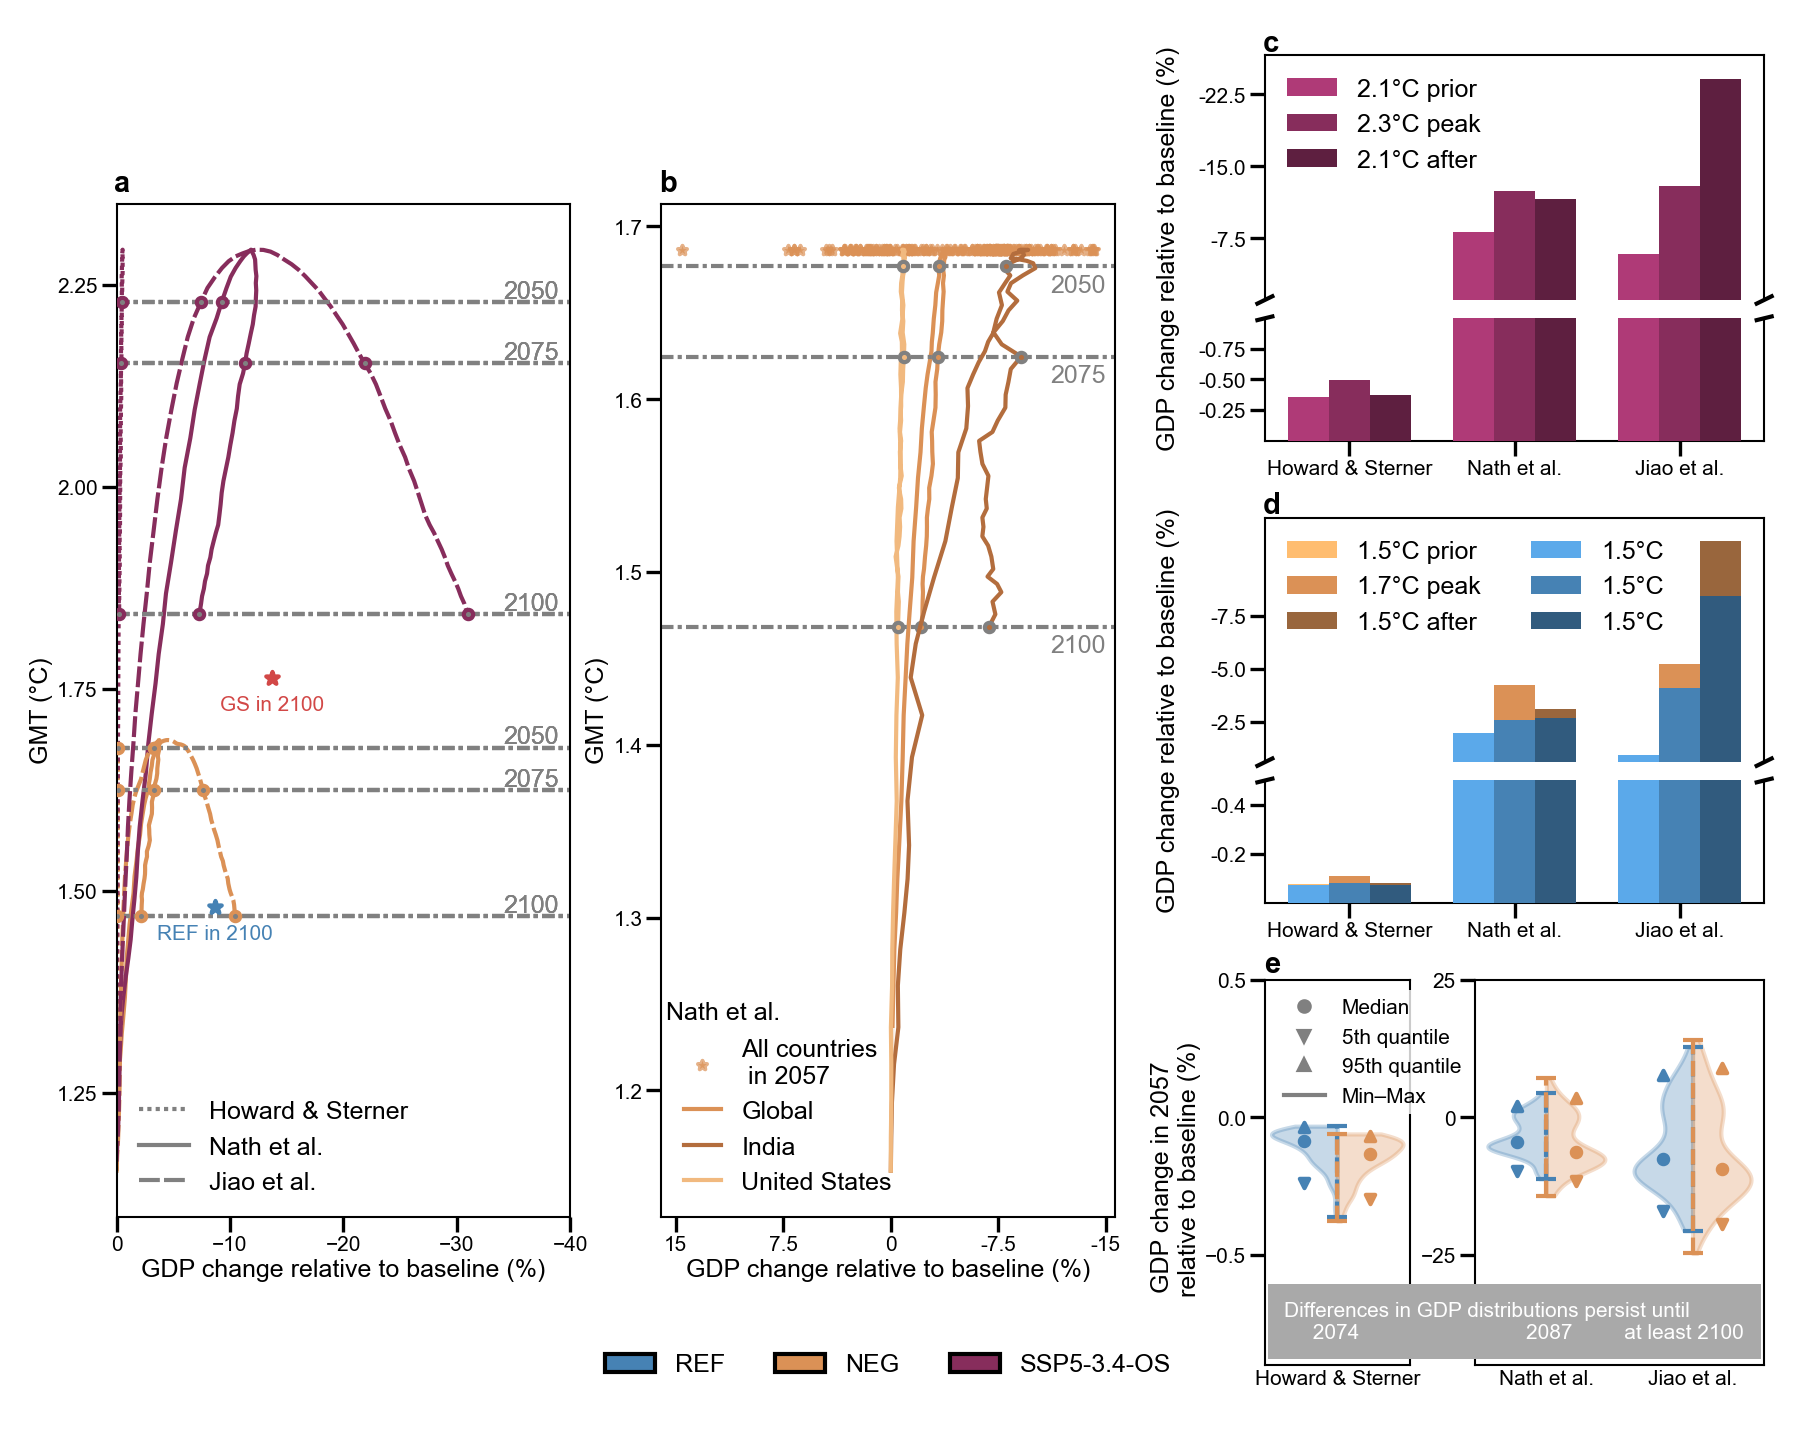

In [63]:
# --- Setup ---
scenarios = ['Ref', 'Neg', 'ssp534-over']
markers = ['x', 'o', 'v']  # One per damage function
linestyles = [(0, (1,1)), '-', (0, (5,1))]
labels = cset.GDP_labels
color_dict = cset.focus_scenarios_color_dict
countries = ['IND', 'USA']
country_labels = ['India', 'United States']
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.4,1,2))
focus_scenarios_color_dict = cset.focus_scenarios_color_dict
sel_var = 'SSP2_diff'
sel_scenario_clor_dict = dict(zip(scenarios, [focus_scenarios_color_dict[scen] for scen in scenarios]))

axes = []
# Create the figure
fig = plt.figure(figsize=(cset.fig_width, cset.fig_height*4/5), dpi=cset.dpi)

gs_outer = gridspec.GridSpec(1, 2, width_ratios=[1, 0.5], figure=fig, wspace=0.2)

gs_left = gridspec.GridSpecFromSubplotSpec(
    nrows=9, ncols=2,
    subplot_spec=gs_outer[0]
)
gs_right = gridspec.GridSpecFromSubplotSpec(
    nrows=3, ncols=1,
    subplot_spec=gs_outer[1]
)


# First two subplots (full height)
ax1 = fig.add_subplot(gs_left[1:-1, 0])  # All rows in column 0
beyond_peak_warming_median_swapped(ax1, gdp_dfs, scenarios[1:], markers, linestyles, labels, color_dict)
axes.append(ax1)

ax2 = fig.add_subplot(gs_left[1:-1, 1])  # All rows in column 1
beyond_peak_warming_countries_swapped(ax2, countries, country_labels, color_dict, scenario = 'Neg', gdp_df = gdp_dfs[1])
axes.append(ax2)

# Third subplot (centered vertically, 75% height -> rows 1 to 3 of 4)
ax3a, ax3b = plot_scenario_broken_y(fig, 
                       gs_right[0], 
                       reversibility_df, 
                       scenarios='ssp534-over', 
                       color_dict=cset.scenarios_color_dict,
                       y_break=1, 
                       gap=0.1, 
                       y_ticks_bottom = [0.25, 0.5, 0.75],
                       y_ticks_top = [7.5, 15, 22.5]
                       )
axes.append(ax3a)

# Third subplot (centered vertically, 75% height -> rows 1 to 3 of 4)
ax4a, ax4b = plot_scenario_broken_y(fig, 
                       gs_right[1], 
                       reversibility_df, 
                       scenarios=['Neg', 'Ref'], 
                       color_dict=cset.scenarios_color_dict,
                       y_break=0.5, 
                       gap=0.1, 
                       y_ticks_bottom = [0.2, 0.4],
                       y_ticks_top = [2.5, 5, 7.5]
                       )
axes.append(ax4a)

# Third subplot (centered vertically, 75% height -> rows 1 to 3 of 4)

# ax5a, ax5b = plot_gdp_half_violin_broken_x(fig,
#                                            gs_right[2], 
#                                            gdp_dfs, 
#                                            2057, 
#                                            sel_var, 
#                                            focus_scenarios_color_dict,
#                                            y_ticks_left=[99.5,100,100.5],
#                                            y_ticks_right = [75,100,125],
#                                            y_lim_left = (99.1, 100.5),
#                                            y_lim_right = (55, 125)
#                                            )
ax5a, ax5b = plot_gdp_half_violin_broken_x(fig,
                                           gs_right[2], 
                                           gdp_dfs, 
                                           2057, 
                                           sel_var, 
                                           focus_scenarios_color_dict,
                                           y_ticks_left=[-0.5,0,0.5],
                                           y_ticks_right = [-25,0,25],
                                           y_lim_left = (-0.9, 0.5),
                                           y_lim_right = (-45, 25)
                                           )
box = ax5b.text(-0.658, 0.06, 
            'Differences in GDP distributions persist until \n     2074                             2087         at least 2100',
            fontsize = labelsize_small, ha='left', va='bottom',
            transform=ax5b.transAxes, 
            zorder = 20,
            color = 'white'
            )
box.set_bbox(dict(facecolor='darkgrey', alpha=1, edgecolor='none'))

axes.append(ax5a)

ax =  fig.add_subplot(gs_left[-1, 1])
for spine in ax.spines.values():
    spine.set_visible(False)  # Hide the spines
ax.set_axis_off()
# Create custom legend elements for each scenario using colored squares (or Line2D if preferred)
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=cset.scenario_names_dict[scenario])
    for scenario, color in sel_scenario_clor_dict.items()
]
ax.legend(
    handles=legend_elements,
    loc='lower center',
    frameon=False,
    fontsize= labelsize_medium,
    ncols = 3
)
pos = ax.get_position()
# move down a bit, reduce width slightly if needed
ax.set_position([pos.x0, pos.y0-0.02, pos.width, pos.height])

y_offsets = [1.02, 1.02, 1.05, 1.05, 1.04]
for label, ax, y_offset in zip(['a', 'b', 'c', 'd', 'e', 'f'], axes, y_offsets):
    ax.text(-0.005, y_offset, label, ha='left', va='center', fontsize=labelsize_large, fontweight='bold', transform=ax.transAxes)

fig.tight_layout()
plt.savefig(cset.path_GRAPHICS / '003_beyond_peak_warming.pdf', bbox_inches='tight', dpi=cset.dpi)
plt.show()

### LATEX TABLES

In [24]:
df = reversibility_df.copy()
df['GMT'] = df['GMT'].round(1)
df['MedianGDPloss'] = df['MedianGDPloss'].round(2)
df = df.set_index('DamageType')
from tabulate import tabulate
Path(cset.path_LATEX_TABLES).mkdir(parents=True, exist_ok=True)

with open(cset.latex_reversibility_file, 'w') as f:
    f.write(tabulate(df, tablefmt='latex'))

with open(cset.latex_reversibility_file, 'w') as f:
    f.write(tabulate(df, tablefmt='latex'))

In [30]:
df_reset = df.reset_index()
# Filter Neg and Ref scenarios
neg_df = df_reset[df_reset['Scenario'] == 'Neg']
ref_df = df_reset[df_reset['Scenario'] == 'Ref']

# Merge on DamageType and Year to align Neg and Ref rows
merged = pd.merge(
    neg_df,
    ref_df,
    on=['DamageType', 'Year'],
    suffixes=('_Neg', '_Ref')
)

# Compute relative GDP loss: Neg / Ref
merged['RelativeLoss'] = merged['MedianGDPloss_Neg'] / merged['MedianGDPloss_Ref']

# Select relevant columns
result_df = merged[[
    'DamageType',
    'Year',
    'Year numeric_Neg',  # Keep Year numeric from Neg (same as Ref, but you can choose)
    'MedianGDPloss_Neg',
    'MedianGDPloss_Ref',
    'RelativeLoss'
]].rename(columns={'Year numeric_Neg': 'YearNumeric'})

# Optional: sort or set index
result_df = result_df.sort_values(['DamageType', 'Year']).reset_index(drop=True)

result_df = result_df.set_index('DamageType')

from tabulate import tabulate
Path(cset.path_LATEX_TABLES).mkdir(parents=True, exist_ok=True)

with open(cset.latex_reversibility_NegvsRef_file, 'w') as f:
    f.write(tabulate(result_df, tablefmt='latex'))

with open(cset.latex_reversibility_NegvsRef_file, 'w') as f:
    f.write(tabulate(result_df, tablefmt='latex'))

         DamageType    Year  YearNumeric  MedianGDPloss_Neg  \
0  Howard & Sterner   After       2088.0               0.08   
1  Howard & Sterner  Before       2033.0               0.08   
2  Howard & Sterner    Peak       2057.0               0.11   
3       Jiao et al.   After       2088.0              11.02   
4       Jiao et al.  Before       2033.0               0.95   
5       Jiao et al.    Peak       2057.0               5.22   
6       Nath et al.   After       2088.0               3.10   
7       Nath et al.  Before       2033.0               1.79   
8       Nath et al.    Peak       2057.0               4.24   

   MedianGDPloss_Ref  RelativeLoss  
0               0.07      1.142857  
1               0.07      1.142857  
2               0.08      1.375000  
3               8.41      1.310345  
4               0.96      0.989583  
5               4.11      1.270073  
6               2.66      1.165414  
7               1.99      0.899497  
8               2.59      1.637066  